In [1]:
# Imports

import jax
import jax.numpy as jnp
from jax.numpy import sin, cos
import numpy as onp
import immrax as irx
import equinox as eqx
import equinox.nn as nn
from pathlib import Path
import optax
from functools import partial 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
from immutabledict import immutabledict
import jax.experimental.compilation_cache.compilation_cache as cc
import os
from jax.scipy.linalg import block_diag
from control import lqr
from time import time

device = 'gpu'

# if device == 'gpu' :
#     cc.initialize_cache('cache')

def jit (f, *args, **kwargs) :
    kwargs.setdefault('backend', device)
    return eqx.filter_jit(f, *args, **kwargs)


In [2]:
class Segway (irx.OpenLoopSystem) :
    def __init__ (self) :
        self.evolution = 'continuous'
        self.xlen = 3
        self.c1 = 1.8
        self.c2 = 11.5
        self.c3 = 10.9
        self.c4 = 68.4
        self.c5 = 1.2
        self.d1 = 9.3
        self.d2 = 58.8
        self.d3 = 38.6
        self.d4 = 234.5
        self.d5 = 208.3
        self.b = 24.7
    def f(self, t, x, u, w) :
        phi, v, phid = x.ravel()
        u = u[0]
        c1 = (1+w[0])*1.8
        c2 = (1+w[1])*11.5
        c3 = (1+w[2])*10.9
        c4 = (1+w[3])*68.4
        c5 = (1+w[4])*1.2
        d1 = (1+w[5])*9.3
        d2 = (1+w[6])*58.8
        d3 = (1+w[7])*38.6
        d4 = (1+w[8])*234.5
        d5 = (1+w[9])*208.3
        b  = (1+w[10])*24.7
        return jnp.array([
            phid,
            (cos(phi)*(-c1*u + c2*v + 9.8*sin(phi)) - c3*u + c4*v - c5*phid**2*sin(phi))/(cos(phi) - b),
            ((d1*u - d2*v)*cos(phi) + d3*u - d4*v - sin(phi)*(d5 + phid**2*cos(phi)))/(cos(phi)**2 - b)
        ])

sys = Segway()
# w = irx.icentpert(0.01*jnp.ones(11), 0.01)
w = irx.icentpert(jnp.zeros(11), 0.02)
# w = irx.icentpert(jnp.zeros(1), 0.)

w_parts = irx.utils.get_partitions_ut(irx.i2ut(w), 2**11)
print(len(w_parts))

2048


In [3]:
## Using closed-loop linearized system to inform nice polytope

A = jax.jacfwd(sys.f, 1)(0., jnp.array([0., 0., 0.]), jnp.array([0.]), jnp.zeros(1))
B = jax.jacfwd(sys.f, 2)(0., jnp.array([0., 0., 0.]), jnp.array([0.]), jnp.zeros(1))
Q = 10*jnp.eye(3)
R = jnp.eye(1)
LQR_K, _, _ = lqr(A, B, Q, R)
LQR_K = -LQR_K
Acl = A + B@LQR_K
L, U = jax.jit(jnp.linalg.eig, backend='cpu')(Acl)

print(A, B, LQR_K, L, U)

L = onp.real_if_close(L); U = onp.real_if_close(U)
reL = onp.real(L); imL = onp.imag(L)

# Convert to Jordan form (real)
Tinv = onp.empty_like(U, dtype=onp.float64)
real_idx = []; polar_tuples = []
skip = False
for i, l in enumerate(L) :
    v = onp.real_if_close(U[:,i])
    if not skip :
        if onp.iscomplex(l) :
            polar_tuples.append((i,i+1))
            rel = onp.real(l); iml = onp.imag(l)
            rev = onp.real(v); imv = onp.imag(v)
            Tinv[:,i] = -rev; Tinv[:,i+1] = imv
            skip = True
        else :
            real_idx.append(i)
            Tinv[:,i] = v
    else :
        skip = False
Tinv[onp.abs(Tinv) < 1e-10] = 0
T = onp.linalg.inv(Tinv); T[onp.abs(T) < 1e-10] = 0


[[ 0.         0.         1.       ]
 [-0.4135021 -3.3713078  0.       ]
 [ 8.789029  12.375526   0.       ]] [[ 0.        ]
 [ 0.53586495]
 [-2.021097  ]] [[19.02420782 12.50859665  7.39037132]] [-8.249025 +0.j         -1.6780119+0.71210283j -1.6780119-0.71210283j] [[ 0.11707944+0.j         -0.41096148-0.17440093j -0.41096148+0.17440093j]
 [ 0.23138824+0.j          0.10845505+0.3559208j   0.10845505-0.3559208j ]
 [-0.9657908 +0.j          0.8137892 +0.j          0.8137892 -0.j        ]]


In [4]:
H = jnp.vstack((
    T,
    # jnp.array([1., 0., 0.])
))
print(f'{H=}')

y = irx.izeros(3)

Hdag = jnp.linalg.pinv(H)
NH = irx.utils.null_space(H.T)

print(jnp.allclose(NH.T @ H, 0., atol=1e-5))

IH = jit(irx.utils.I_refine(NH.T))

H=Array([[-5.149507 , -2.5232546, -2.2642095],
       [ 6.111345 ,  2.9945545,  1.458305 ],
       [ 5.209984 ,  5.362502 ,  1.916359 ]], dtype=float32)
True


In [5]:
def build_lifted_embsys (net, eta) :
    Hp = Hdag + eta@NH.T
    # Hp = Hdag

    lifted_sys = irx.LiftedSystem(sys, H, Hp)
    def lifted_net (y) :
        return net(Hp @ y)
    lifted_net.out_len = net.out_len

    lifted_clsys = irx.NNCSystem(lifted_sys, lifted_net)
    lifted_embsys = irx.NNCEmbeddingSystem(lifted_clsys, 'crown', 'local', 'local')
    return lifted_embsys

# net = irx.NeuralNetwork('./models/100r100r2', False)
net = irx.NeuralNetwork('./models/32r32r1', False)
eta = jnp.zeros((3,len(NH.T)))

params = (net, eta)

In [6]:
def Laccuracy (net:irx.NeuralNetwork, key) :
    X = jax.random.uniform(key, (1000,3), minval=jnp.array([-jnp.pi/2, -5., -2*jnp.pi]), maxval=jnp.array([jnp.pi/2, 5., 2*jnp.pi]))
    return jnp.mean((jax.vmap(net)(X) - jax.vmap(lambda x : LQR_K@x)(X))**2)

permutations = irx.standard_permutation(1+len(H)+1+len(w)) 
corners = irx.bot_corner (1+len(H)+1+len(w))

@jit
def EH (net:irx.NeuralNetwork, eta:jax.Array, y) :
    lifted_embsys = build_lifted_embsys(net, eta)
    def eval_w(w) :
        return lifted_embsys.E(0., irx.i2ut(y), irx.ut2i(w), permutations=permutations, 
            corners=corners, refine=IH)
    Es = jax.vmap(eval_w)(w_parts)    
    
    return jnp.concatenate((jnp.min(Es[:,:len(H)], axis=0), jnp.max(Es[:,len(H):], axis=0)))
    # return lifted_embsys.E(0., irx.i2ut(y), w, permutations=permutations,
    #         corners=corners, refine=IH)

def LH (net:irx.NeuralNetwork, eta:jax.Array, y, epsl:float=0.1, epsu:float=0.1) :
    E = EH(net, eta, y)
    def relu_eps (x, eps) :
        return jax.nn.relu(x + eps)
    
    # Induce SE positivity in the lifted embedding system
    return jnp.sum(jax.vmap(partial(relu_eps, eps=epsl))(-E[:len(H)])) \
         + jnp.sum(jax.vmap(partial(relu_eps, eps=epsu))( E[len(H):])) 

def loss(params, key, y) :
    net, eta = params
    return Laccuracy(net, key) + 1000.*LH(net, eta, y) 

# t0 = time()
# EH (net, eta, y)
# tf = time()
# print(f'JIT compiled EH in {tf - t0} seconds.')

In [7]:
optim = optax.adam(0.001)

@jit
def make_step (params, key, opt_state, y) :
    loss_value, grads = eqx.filter_value_and_grad(loss)(params, key, y)
    updates, opt_state = optim.update(grads, opt_state, params)
    params = eqx.apply_updates(params, updates)
    net, eta = params
    return (params, opt_state, loss_value, jnp.sqrt(Laccuracy(net, key)), EH(net, eta, y))

t0 = time()
make_step(params, jax.random.key(0), optim.init(eqx.filter(params, eqx.is_array)), y)
tf = time()
print(f'JIT compiled make_step in {tf - t0} seconds.')

JIT compiled make_step in 139.37694478034973 seconds.


In [8]:
# Initial set
Tinit = irx.icentpert(jnp.zeros(3), 0.15) 

y = irx.iconcatenate((Tinit,))
trainable = jnp.array([False, False, False])
swhere = jnp.where(trainable)
print(f'{y=}')


y=[[(-0.15000001, 0.15000001)]
 [(-0.15000001, 0.15000001)]
 [(-0.15000001, 0.15000001)]]


In [9]:
net = irx.NeuralNetwork('./models/32r32r1', False)

def train(params, optim, steps, minsteps, print_every=1) -> irx.NeuralNetwork :
    opt_state = optim.init(eqx.filter(params, eqx.is_array))

    for step in range(steps) :
        key = jax.random.key(step)
        params, opt_state, train_loss, RMSE, EHval = make_step(params, key, opt_state, y)
        if (step % print_every) == 0 or (step == steps - 1) :
            net, eta = params
            net.save()
            print(
                f'{step=}, train_loss={train_loss.item()}, RMSE={jnp.sqrt(RMSE.item())},'
                f'\nEHl={EHval[:len(H)]}, \nEHu={EHval[len(H):]}'
                f'\neta={eta}'
            )
        if (jnp.all(EHval[:len(H)] >= 0) 
            and jnp.all(EHval[len(H):] <= 0)
            and step >= minsteps) :
            print('EH constraints satisfied, stopping training')
            print(
                f'{step=}, train_loss={train_loss.item()}, RMSE={RMSE},'
                f'\nEHl={EHval[:len(H)]}, \nEHu={EHval[len(H):]}'
                f'\neta={eta} \n'
            )
            return params
    
    return params

t0 = time()
net, eta = train((net, eta), optim, 100000, 100, 100)
tf = time()
print(f'Finished training in {tf - t0} seconds.')
net.save()
onp.save(net.dir / 'H.npy', H)
onp.save(net.dir / 'ylyu.npy', irx.i2lu(y))


Saving model to models/32r32r1/model.eqx... done.
step=0, train_loss=6119.490234375, RMSE=6.953171730041504,
EHl=[-0.6745812  -0.32507515 -0.3797142 ], 
EHu=[0.58853555 0.5659495  0.6282555 ]
eta=[]
Saving model to models/32r32r1/model.eqx... done.
step=100, train_loss=4995.89404296875, RMSE=6.601227760314941,
EHl=[-0.22360182 -0.30207506 -0.3745619 ], 
EHu=[0.55875695 0.43032667 0.57988507]
eta=[]
Saving model to models/32r32r1/model.eqx... done.
step=200, train_loss=1898.01904296875, RMSE=5.070024013519287,
EHl=[ 0.24571407  0.01460415 -0.13463771], 
EHu=[-0.2049548   0.25757766  0.4431626 ]
eta=[]
Saving model to models/32r32r1/model.eqx... done.
step=300, train_loss=531.2431640625, RMSE=2.9823429584503174,
EHl=[ 0.7495358   0.11938441 -0.04859102], 
EHu=[-0.16087085 -0.10383585  0.19782227]
eta=[]
Saving model to models/32r32r1/model.eqx... done.
step=400, train_loss=296.08074951171875, RMSE=2.228816509246826,
EHl=[0.7884375  0.16520602 0.07174903], 
EHu=[-0.33579195 -0.08770159  0

EH verified True in 0.023180007934570312 seconds.
[ 1.1339561   0.05625331  0.01777911 -0.06345642 -0.15763825 -0.00445709] >=_SE 0
[[ 0.07024245  0.02280023 -0.10436462]
 [ 0.1053663  -0.26693708 -0.03494814]
 [ 0.05304601 -0.26693705  0.0718281 ]
 [ 0.01792217  0.02280024  0.00241163]
 [-0.07024245 -0.02280023  0.10436462]
 [-0.1053663   0.26693708  0.03494814]
 [-0.01792217 -0.02280024 -0.00241163]
 [-0.05304601  0.26693705 -0.0718281 ]]
Volume of polytope: 0.0015186705886582798
Volume of ellipsoid: 0.15754996288688577


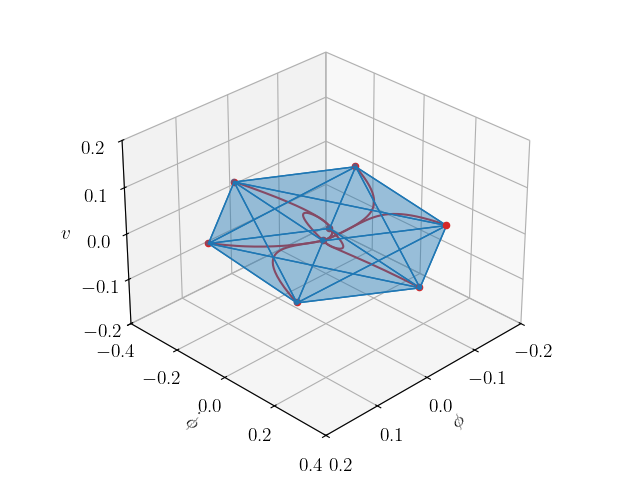

In [14]:
from pypoman import compute_polytope_vertices
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial import ConvexHull
%matplotlib widget

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size": 14
})
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.tight_layout()

t0 = time()
E = EH(net, eta, y)
is_FI = jnp.all(E[:len(H)] >= 0) and jnp.all(E[len(H):] <= 0)
tf = time()
print(f'EH verified {is_FI} in {tf - t0} seconds.')
print(f'{E} >=_SE 0')

Hp = Hdag + eta@NH.T

# Plotting the polytope

H_plot = onp.vstack((-H, H))
b = onp.concatenate((-y.lower, y.upper))

vertices = onp.array(compute_polytope_vertices(H_plot, b)).astype(onp.float32)

mcx0s = jnp.array(vertices)

vertices[:,[1,2]] = vertices[:,[2,1]]
print(vertices)

hull = ConvexHull(vertices)
print(f'Volume of polytope: {hull.volume}')


for s in hull.simplices:
    tri = Poly3DCollection([vertices[s]])
    tri.set_color('tab:blue')
    tri.set_alpha(0.25)
    ax.add_collection3d(tri)
ax.scatter(vertices[:,0], vertices[:,1], vertices[:,2], color='tab:blue', s=10, marker='o')

# Plotting monte carlo simulations from the vertices

clsys = irx.NNCSystem(sys, net)

def w_map (t, x) :
    return jnp.array([0.])

def compute_traj (x0) :
    return clsys.compute_trajectory(0., 5., x0, (w_map,), 0.01, solver='tsit5')

mc_traj = jax.vmap(compute_traj)(mcx0s)
tfinite = jnp.isfinite(mc_traj.ts[0,:])

for i in range(len(mcx0s)) :
    xx = mc_traj.ys[i]
    ax.plot(xx[tfinite,0], xx[tfinite,2], xx[tfinite,1], color='tab:red', zorder=0)
    ax.scatter(xx[0,0], xx[0,2], xx[0,1], color='tab:red', zorder=0)
 
# set azim and elev
ax.view_init(azim=45, elev=30)

ax.set_xlabel(r'$\phi$')
ax.set_ylabel(r'$\dot{\phi}$')
ax.set_zlabel(r'$v$')

ax.set_xlim([-0.2, 0.2])
ax.set_ylim([-0.4, 0.4])
ax.set_zlim([-0.2, 0.2])

# Plot FI-ODE Ellipsoid

P = jnp.array([[ 0.7302, -0.2806,  0.2326],
        [ 1.7148,  0.3842,  0.2007],
        [-0.0236,  0.2314,  0.7688]])
P = P.T @ P

print(f'Volume of ellipsoid: {(4/3)*onp.pi*(0.15)**(3/2) * (onp.linalg.det(P))**(1/2)}')

# U, s, rotation = onp.linalg.svd(P/0.15)
# radii = 1.0/onp.sqrt(s)
# u = onp.linspace(0.0, 2.0 * onp.pi, 100)
# v = onp.linspace(0.0, onp.pi, 100)
# poly_x = radii[0] * onp.outer(onp.cos(u), onp.sin(v))
# poly_y = radii[1] * onp.outer(onp.sin(u), onp.sin(v))
# poly_z = radii[2] * onp.outer(onp.ones_like(u), onp.cos(v))
# for i in range(len(poly_x)):
#     for j in range(len(poly_x)):
#         [poly_x[i,j],poly_y[i,j],poly_z[i,j]] = onp.dot([poly_x[i,j],poly_y[i,j],poly_z[i,j]], rotation) + jnp.array([0., 0., 0.])

# ax.plot_surface(poly_x, poly_y, poly_z, color='tab:green', alpha=0.25)

fig.tight_layout()
plt.savefig('segway.pdf')

plt.show()